In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

In [2]:
from project_alpha.cleaning import RegexCleaner, OutlierCapper
from project_alpha.features import MissingValueImputer, FeatureEngineer

In [4]:
# 1. Load Data
df = pd.read_csv('../data/raw_data.csv', low_memory=False)

In [5]:
# 2. Preprocessing (Mirroring train.py)
# Map Target
target_map = {'Good': 0, 'Standard': 1, 'Poor': 2}
df['target'] = df['Credit_Score'].map(target_map)
df = df.dropna(subset=['target'])

# Drop ID and Text Columns (as decided in train.py)
drop_cols = ['Credit_Score', 'target', 'ID', 'Customer_ID', 'Name', 'SSN', 'Month',
             'Type_of_Loan', 'Credit_History_Age']
X = df.drop(columns=drop_cols, errors='ignore')
y = df['target']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
# 3. Define Pipeline (Same as train.py)
DIRTY_NUMERIC_COLS = [
    'Age', 'Annual_Income', 'Num_of_Loan', 'Num_Bank_Accounts', 
    'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 
    'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries',
    'Outstanding_Debt', 'Monthly_Inhand_Salary', 
    'Total_EMI_per_month', 'Amount_invested_monthly', 'Monthly_Balance'
]

CATEGORICAL_COLS = ['Occupation', 'Credit_Mix', 'Payment_of_Min_Amount', 'Payment_Behaviour']

In [14]:
# Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), CATEGORICAL_COLS)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# Full Pipeline (Linear Sequence - No Nesting!)
model = Pipeline([
    # --- Cleaning Steps (Directly in main pipeline) ---
    ('regex', RegexCleaner(columns=DIRTY_NUMERIC_COLS)),
    ('outliers', OutlierCapper()),
    ('imputer', MissingValueImputer()),
    ('features', FeatureEngineer()),
    
    # --- Encoding ---
    ('preprocessor', preprocessor),
    
    # --- Model ---
    ('classifier', XGBClassifier(
        n_estimators=200, max_depth=6, learning_rate=0.1, 
        objective='multi:softprob', num_class=3, n_jobs=-1, random_state=42
    ))
])

In [15]:
# 4. Train
print("Training model...")
model.fit(X_train, y_train)


Training model...


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('regex', ...), ('outliers', ...), ...]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,columns,"['Age', 'Annual_Income', ...]"
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the outp

In [16]:
# 5. Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Good', 'Standard', 'Poor']))

              precision    recall  f1-score   support

        Good       0.65      0.69      0.67      3566
    Standard       0.77      0.78      0.78     10635
        Poor       0.76      0.71      0.73      5799

    accuracy                           0.74     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.75      0.74      0.74     20000



/tmp/ipykernel_481270/2192318136.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')


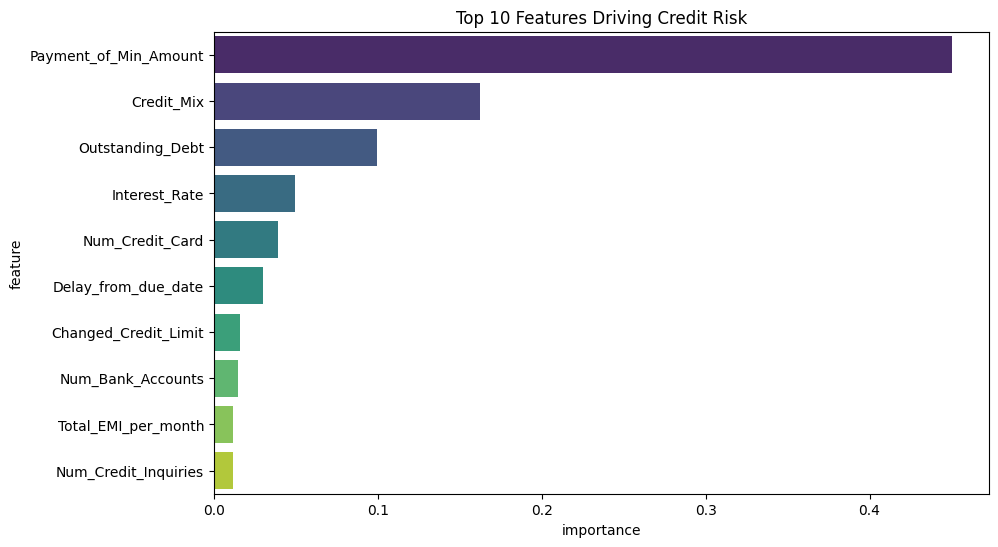

In [17]:
# 6. Feature Importance Visualization
# Extract feature names and importances
# This is a bit tricky with Pipelines, but essential for the "Explainability" rubric
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importances = model.named_steps['classifier'].feature_importances_

# Create a DataFrame for plotting
feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
feat_imp = feat_imp.sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp, palette='viridis')
plt.title("Top 10 Features Driving Credit Risk")
plt.show()

Generating SHAP Explanations...
Data Shape: (500, 23)
SHAP Shape: (500, 23)


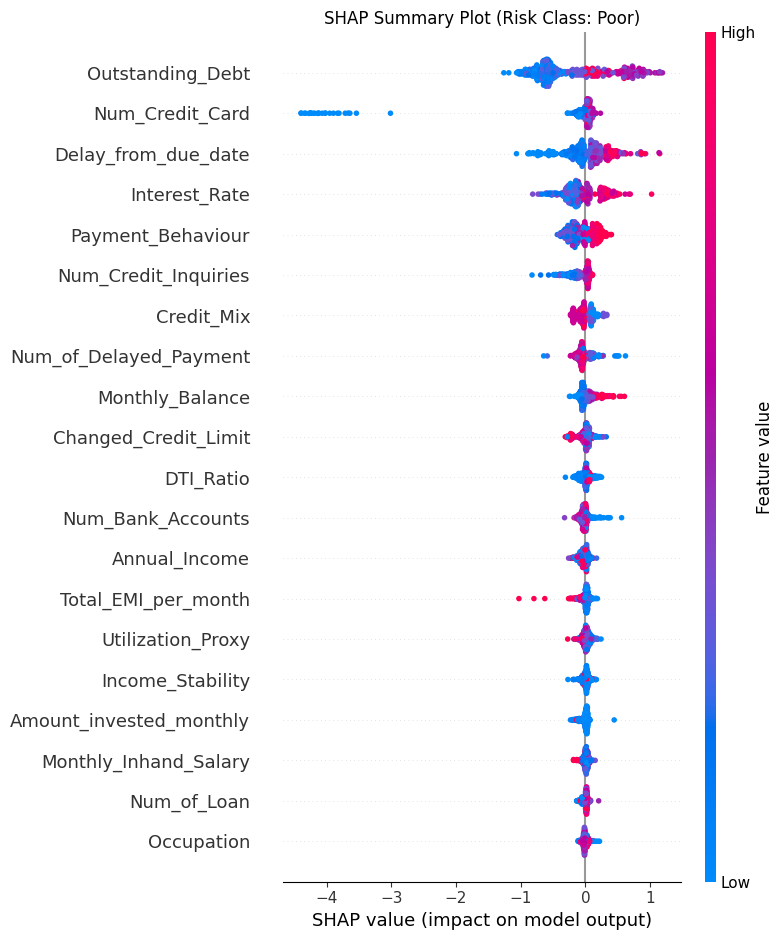

In [21]:
# 7. SHAP Analysis (Universal Fix)
import shap
import numpy as np
print("Generating SHAP Explanations...")

# A. Isolate the Preprocessor
preprocessor_pipe = Pipeline(model.steps[:-1])
X_test_sample = X_test[:500]
X_test_transformed = preprocessor_pipe.transform(X_test_sample)

# Get feature names
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# B. Create the Explainer
explainer = shap.TreeExplainer(model.named_steps['classifier'])
shap_values = explainer.shap_values(X_test_transformed)

# --- FIX: Handle different SHAP return types ---
# Case 1: List (Older SHAP/XGBoost) -> [Class0, Class1, Class2]
if isinstance(shap_values, list):
    risk_class_shap = shap_values[2]
# Case 2: 3D Array (Newer SHAP/XGBoost) -> (Samples, Features, Classes)
elif len(shap_values.shape) == 3:
    risk_class_shap = shap_values[:, :, 2]
else:
    # Binary classification fallback
    risk_class_shap = shap_values

print(f"Data Shape: {X_test_transformed.shape}")
print(f"SHAP Shape: {risk_class_shap.shape}")

# C. Plot
plt.title("SHAP Summary Plot (Risk Class: Poor)")
shap.summary_plot(risk_class_shap, X_test_transformed, feature_names=feature_names)